In [ ]:
import pandas as pd
import numpy as np
import os
import sqlite3
import re
import seaborn as sns   
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys

# connect to directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# import the mentions ai function
from mentions_ai import flag_ai_mentions



In [11]:
# connect to subdirectory
db_path = os.path.abspath(os.path.join(os.getcwd(), "DB", "articlesWSJ_clean_final_2024.db"))

# Connect to the database
conn = sqlite3.connect(db_path)

# explore table names
query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = pd.read_sql_query(query, conn)
print("Table names in the database:")
print(table_names)

df = pd.read_sql_query("SELECT * FROM article", conn)
conn.close()

Table names in the database:
                     name
0  articles_index_cleaned
1          articles_index
2                 article


In [126]:
# perform initial analysis
print("Number of rows in the DataFrame:", len(df))
print("Number of columns in the DataFrame:", len(df.columns))   
print("Columns in the DataFrame:", df.columns.tolist())

Number of rows in the DataFrame: 14258
Number of columns in the DataFrame: 8
Columns in the DataFrame: ['article_id', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'section', 'date']


Flag articles which contain "AI, A.I., artificial intelligence, machine learning, deep learning, LLM, GPT, ChatGPT, OpenAI, transformer model or generative AI" (case-insensitive and uses word boundaries).  

In [128]:
# check for AI-related articles using importflag_ai_mentions from mentions_ai.py
df_labeled = flag_ai_mentions(df)

1307 out of 14258 articles mention AI-related topics.


Analyze distribution by section and evolution over time

In [129]:
# fractioin of AI-related articles
print("Fraction of AI-related articles:", df_labeled["mentions_ai"].sum() / len(df_labeled))

# sections in the dataset
sections = df_labeled["section"].unique()
print("Sections in the dataset:", sections)

# create list of count for each section
section_counts = df_labeled["section"].value_counts()
print("Counts of articles in each section:", section_counts)

# crea a list of counts for each section by ai_relatedness
section_ai_counts = df_labeled.groupby(["section", "mentions_ai"]).size().unstack(fill_value=0)  
print("Counts of articles in each section by AI-relatedness:", section_ai_counts)


Fraction of AI-related articles: 0.09166783560106607
Sections in the dataset: ['business' 'opinion' 'world' 'us-news' 'tech' 'finance' 'economy'
 'politics']
Counts of articles in each section: section
opinion     4674
business    2910
world       1764
finance     1588
politics    1127
us-news      768
tech         731
economy      696
Name: count, dtype: int64
Counts of articles in each section by AI-relatedness: mentions_ai  False  True 
section                  
business      2604    306
economy        653     43
finance       1358    230
opinion       4490    184
politics      1075     52
tech           307    424
us-news        749     19
world         1715     49


In [131]:
# normalize the daily counts by total counts of the given day
daily_counts_grouped = df_labeled.groupby(["date", "mentions_ai"]).size().unstack(fill_value=0).reset_index()
daily_counts_grouped["frac_ai"] = daily_counts_grouped[1] / (daily_counts_grouped[0] + daily_counts_grouped[1]) 
# 
print(daily_counts_grouped.head())

mentions_ai                 date  False  True   frac_ai
0            2024-01-01 00:00:00     37     1  0.026316
1            2024-01-02 00:00:00     74     1  0.013333
2            2024-01-03 00:00:00     42     4  0.086957
3            2024-01-04 00:00:00     54     5  0.084746
4            2024-01-05 00:00:00     53     2  0.036364


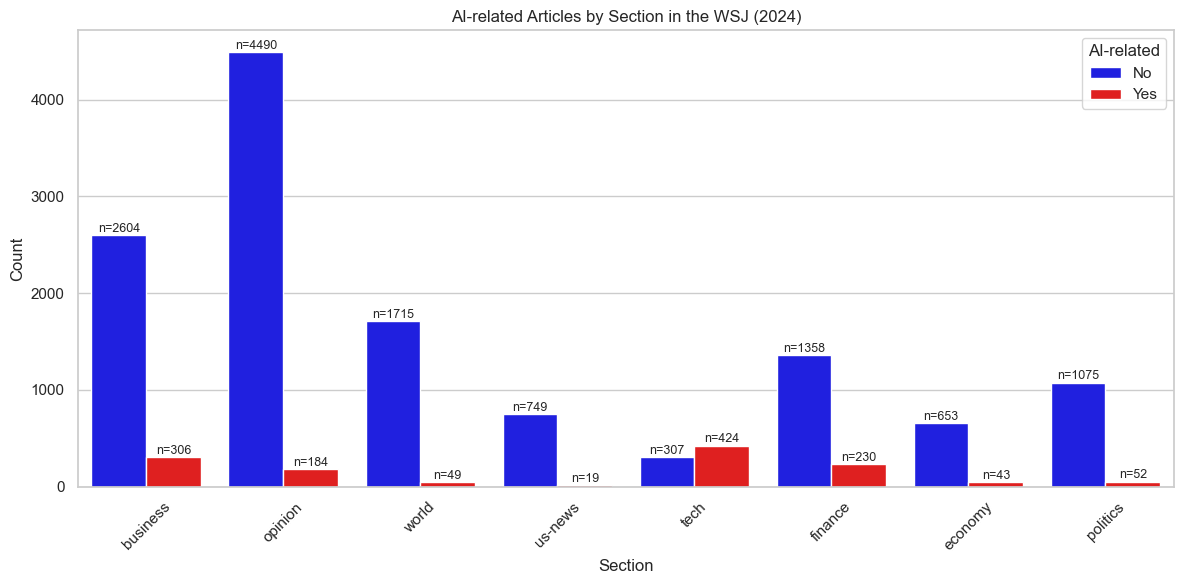

In [ ]:
# v isualize the data using seaborn
# Set the style of seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 

# Create the countplot
ax = sns.countplot(data=df_labeled, x="section", hue="mentions_ai", palette=["blue", "red"])

# Add bar labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,  # x-position
            height + 1,                     # y-position 
            f'n={int(height)}',             # text label
            ha="center", va="bottom", fontsize=9
        )

# Final plot formatting
plt.title("AI-related Articles by Section in the WSJ (2024)")
plt.xlabel("Section")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="AI-related", loc="upper right", labels=["No", "Yes"])
plt.tight_layout()
plt.savefig("WSJ_articles_by_section.png", dpi=300)
plt.show()


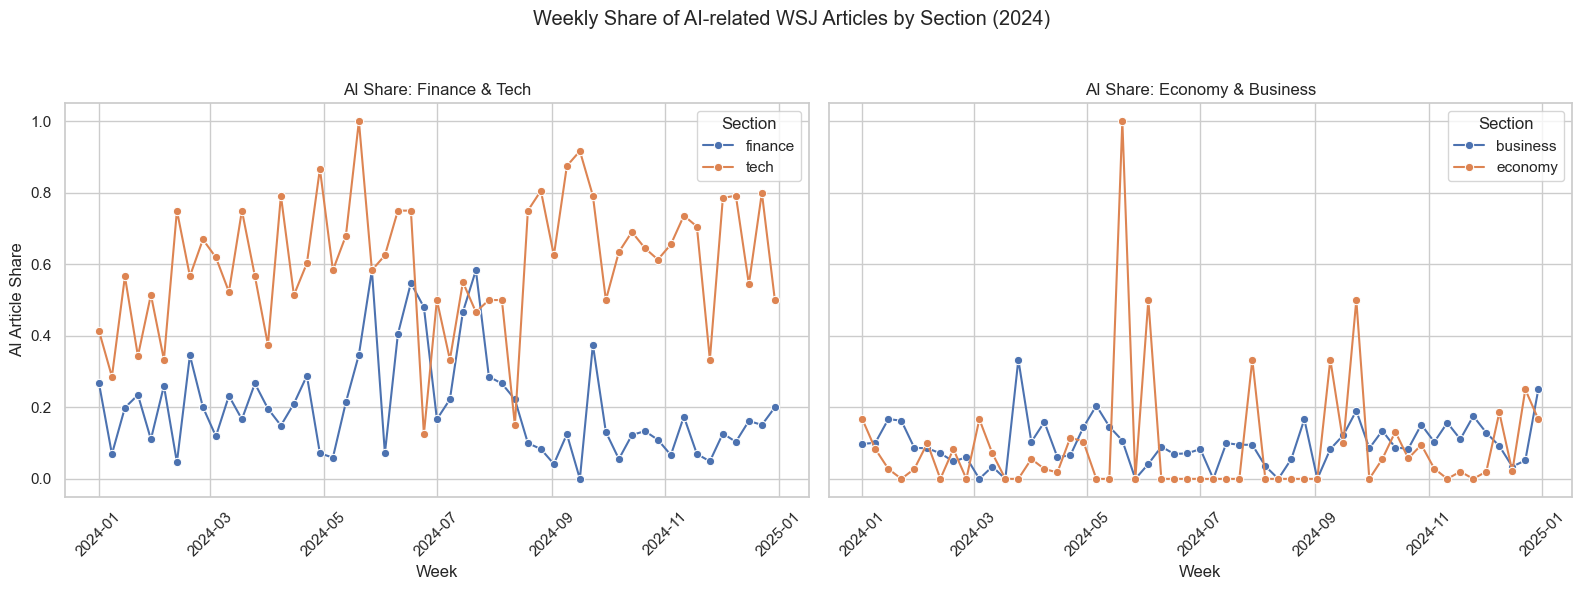

In [ ]:
# Filter sections for each subplot 
left_sections = ["finance", "tech"]
right_sections = ["economy", "business"]

# Two filtered DataFrames
left_df = weekly_section[weekly_section["section"].isin(left_sections)]
right_df = weekly_section[weekly_section["section"].isin(right_sections)]

#  plot configuration
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Left subplot: finance & tech
sns.lineplot(
    data=left_df,
    x="date", y="frac_ai", hue="section",
    marker='o', ax=ax1
)
ax1.set_title("AI Share: Finance & Tech")
ax1.set_xlabel("Week")
ax1.set_ylabel("AI Article Share")
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="Section")

# Right subplot: economy & business
sns.lineplot(
    data=right_df,
    x="date", y="frac_ai", hue="section",
    marker='o', ax=ax2
)
ax2.set_title("AI Share: Economy & Business")
ax2.set_xlabel("Week")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title="Section")

# Final layout
plt.suptitle("Weekly Share of AI-related WSJ Articles by Section (2024)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("WSJ_frac_ai_by_section_split.png", dpi=300)
plt.show()


Next, the number of articles per day is analyzed

In [ ]:
# group by day and count
daily_counts = df_labeled.groupby(df_labeled['date'].dt.date).size().reset_index(name='count')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Show all rows in notebook or script
pd.set_option('display.max_rows', None)

# Filter and display
display(daily_counts[daily_counts['count'] < 25])